In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import scipy
from numpy.linalg import inv
import math
import statsmodels.api as sm

## Q2

### a.	Download a panel of CMT rates into pandas dataframe & remove ‘1M column from the dataset

In [2]:
data = quandl.get("USTREASURY/YIELD", authtoken="ZCV6LPCJDSYJ3BB7k7-E") #you may need to use your own authtoken
data = data.drop(['1 MO', '2 MO'],1)
df = data['2012-1-2':'2015-12-31']
df.head()

3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  20 YR  30 YR
Date                                                                     
2012-01-03  0.02  0.06  0.12  0.27  0.40  0.89  1.41   1.97   2.67   2.98
2012-01-04  0.02  0.06  0.12  0.25  0.40  0.89  1.43   2.00   2.71   3.03
2012-01-05  0.02  0.07  0.11  0.27  0.40  0.88  1.43   2.02   2.74   3.06
2012-01-06  0.02  0.05  0.12  0.25  0.40  0.86  1.40   1.98   2.70   3.02
2012-01-09  0.01  0.05  0.11  0.26  0.38  0.85  1.39   1.98   2.70   3.02

### b.	Perform PCA on the dataset using Sample1

In [3]:
#using difference data and remove mean
df1 = df.diff(periods=1).dropna()
norm = df1 -df1.mean()

#manually calculate PCA
def PCA_manual(df):    
    c = df.cov()     
    val, vec = np.linalg.eig(c)
    decor = np.argsort(val)[::-1]
    val, vec = val[decor], vec[:, decor]
    tr = sum(val)
    var_ratio_custom = np.cumsum(np.round(val/tr, decimals=4))
    return val, vec, var_ratio_custom


#Using sklearn to calculate PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(norm)
f=pca.components_
var_ratio = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
print ('% variance explained:\n', var_ratio)
print('PCA loadings(sklearn):\n',f)

print('\n% variance explained (Manual Fuction):\n',PCA_manual(norm)[2])
print('PCA loadings(Manual):\n',PCA_manual(norm)[1])

% variance explained:
 [0.8658 0.943  0.9612 0.9735 0.9811 0.9873 0.9924 0.9954 0.9978 1.    ]
PCA loadings(sklearn):
 [[ 0.01233575  0.0169508   0.0442175   0.16300775  0.25360006  0.38588999
   0.44680445  0.43904734  0.43633856  0.41835581]
 [ 0.03522316  0.07160778  0.13545912  0.41801319  0.5017714   0.37678877
   0.14606942 -0.1044392  -0.39393714 -0.46837255]
 [ 0.5065613   0.57523594  0.43095561  0.26316157  0.0326546  -0.21483626
  -0.23716024 -0.06036315  0.10636891  0.19773349]
 [ 0.4125768   0.32227626 -0.03019416 -0.6630375  -0.1071609   0.22206667
   0.32903336  0.15343987 -0.13896641 -0.27105814]
 [-0.5024806   0.01561248  0.81650218 -0.245483   -0.07930413  0.01179512
   0.09477881  0.04005756 -0.04627548 -0.03427056]
 [ 0.2025303  -0.33484134  0.11607148 -0.44210009  0.70113139 -0.07833637
  -0.24796213 -0.17246051  0.04144526  0.21741737]
 [-0.52466547  0.66614062 -0.32802441 -0.17481243  0.31256688  0.0170517
  -0.14867086 -0.10486528  0.08817122  0.06293397]
 [ 0.04

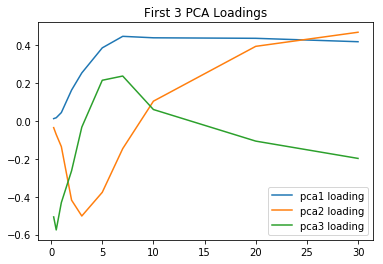

In [4]:
term = [3/12,6/12,1,2,3,5,7,10,20,30] 
plt.plot(term,PCA_manual(norm)[1][:,0],label='pca1 loading')
plt.plot(term,PCA_manual(norm)[1][:,1],label='pca2 loading')
plt.plot(term,PCA_manual(norm)[1][:,2],label='pca3 loading')
plt.title('First 3 PCA Loadings')
plt.legend(loc='lower right') 
plt.show()

### c.	Use this PCA model to analyze the CMT curve move on the Election Day: 11/8/2016 to 11/9/2016

#### i.	Plot CMT curve move vs the move explained by the first PCA factor, first 2 PCA factors, first 3 PCA factors

Note that: Pca was done on the de-meaned series, so explain part needs to be consistent.

You have to explain the move - (historical sample mean) with pca factors, then move explained = pca_explained + historical sample mean.

Also, even thought you don't center the data manually, your cov calculation function still does the de-meaning, therefore the explain part needs to be consistent.


In [5]:
move = data.loc['2016-11-9']-data.loc['2016-11-8']
pca1 = (move-df1.mean())@PCA_manual(norm)[1][:,0]*PCA_manual(norm)[1][:,0].T+df1.mean()
pca2 = (move-df1.mean())@PCA_manual(norm)[1][:,1]*PCA_manual(norm)[1][:,1].T+pca1
pca3 = (move-df1.mean())@PCA_manual(norm)[1][:,2]*PCA_manual(norm)[1][:,2].T+pca2

In [6]:
pca1-df1.mean()

3 MO     0.005623
6 MO     0.007727
1 YR     0.020156
2 YR     0.074304
3 YR     0.115599
5 YR     0.175902
7 YR     0.203668
10 YR    0.200132
20 YR    0.198898
30 YR    0.190701
dtype: float64

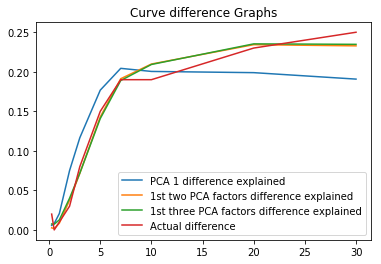

In [7]:
plt.plot(term, pca1, label = 'PCA 1 difference explained')
plt.plot(term, pca2, label = '1st two PCA factors difference explained')
plt.plot(term, pca3, label = '1st three PCA factors difference explained')
plt.plot(term, move, label = 'Actual difference')
plt.legend(loc='best')
plt.title('Curve difference Graphs')
plt.show()

#### ii.	Explain your calculations and results

Calculation Steps:
* use difference data and remove the mean value as input
* calculate eigen values and eigen vectors of the covariance matrix
* The first PCA loading is the eigen vector with the largest eigen value, the 2nd PCA loading is the eigen vector with the second largest eigen value and the 3rd PCA loading is the eigen vector with the thrid largest eigen value



Result:
* The 1st component can roughly explain the curve move well. 
* However, it cannot explain the slope of the curve well. 
* Add the 2nd component make up for that well. Adding the 3rd one make it more close to actual move curve
* We can imagine that when we use more components, the explanation curve will converge to actual move.

### d.	Compute weights of the WFLY to make sure that WFLY does not have PCA1,2 risk exposure in Sample1.  Let’s call this combination WFLY1

In [8]:
#PCA 1 & 2 Factor Neutral Weights 

P_12 = PCA_manual(norm)[1][:,:2]   # P_12 is matrix of 1st two principal components 
coeff = P_12[[5,6,7],:].T         # Exrtacting 1st two principal components for 5, 7 and 10 yrs

'''
From given data we have 3 equations viz. 

w1*PCA1 + w*PCA1 + w2*PCA1 = 0
w1*PCA2 + w*PCA2 + w2*PCA2 = 0
w = -1
Soving these 3 equations for calculating w1 and w2

'''
eq = np.vstack([coeff,[0, 1, 0]]) 
b = np.array([0, 0, -1])
WFLY1_wts = np.linalg.solve(eq,b)
print('PCA Factor 1 & 2 neutral weights are:\n\n[W1_5Yr  W_7Yr  W2_10Yr]:', WFLY1_wts)
WFLY1 = pd.Series(WFLY1_wts[0]*df['5 YR'] + WFLY1_wts[1]*df['7 YR'] + WFLY1_wts[2]*df['10 YR'])

PCA Factor 1 & 2 neutral weights are:

[W1_5Yr  W_7Yr  W2_10Yr]: [ 0.5385467  -1.          0.54432553]


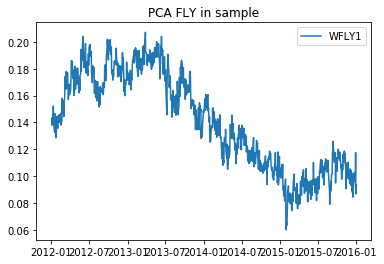

In [9]:
plt.figure()
plt.plot(WFLY1, label = 'WFLY1')
plt.legend(loc = 'best')
plt.title('PCA FLY in sample')
plt.show()

### e.	Choose weights of the WFLY from cointegration analysis (weights correspond to the best cointegrated vector).  Let’s call this combination WFLY2

#### i.	Use Chou-Ng estimation procedure or Box-Tiao (for extra credit)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


Chou-Ng weights:
[W1_5Yr  W_7Yr  W2_10Yr]: [0.6708605983451325, -1, 0.4610507381073649]


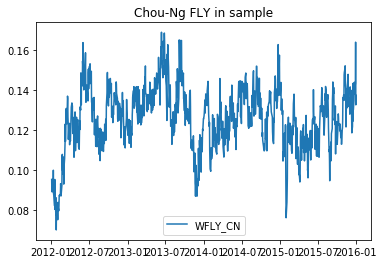

In [10]:
def CCA_Chou_Ng(data_set):
    """
    Chou-Ng estimation prodedure
    """
    #data_set is pandas dataframe
    df_lag = data_set.shift(1).dropna()
    df = data_set.drop(data_set.index[0]).dropna()
    n = len(data_set.columns)
    
    #X(t) ~ M_1 + X(t-1)
    X = df_lag.as_matrix()
    X_I = sm.add_constant(X)
    Y = df.as_matrix()
    l1 = sm.OLS(Y,X_I).fit()
    B=l1.params[1:(n+1)]
    
    #X(t-1) ~ M_2 + X(t)
    Y_I = sm.add_constant(Y)
    l2 = sm.OLS(X,Y_I).fit()
    A=l2.params[1:(n+1)]
    C = np.dot(A,B)
    eig_val, eig_vec = np.linalg.eig(C)
    return eig_val, eig_vec, C

flylist = ['5 YR','7 YR','10 YR']
fly=df.loc['2012-01-01':'2015-12-31',flylist]
val, vec, C = CCA_Chou_Ng(fly)
w = vec[:,0]
w_cca_cn = [-w[0]/w[1],-1,-w[2]/w[1]]
WFLY_CN = pd.Series(w_cca_cn[0]*df['5 YR'] + w_cca_cn[1]*df['7 YR'] + w_cca_cn[2]*df['10 YR'])
print ('Chou-Ng weights:')
print('[W1_5Yr  W_7Yr  W2_10Yr]:',w_cca_cn)
plt.figure()
plt.plot(WFLY_CN, label = 'WFLY_CN')
plt.legend(loc = 'best')
plt.title('Chou-Ng FLY in sample')
plt.show()

Box Tiao CCA weights are:

[W1_5Yr  W_7Yr  W2_10Yr]: [0.6708931059977316, -1, 0.4611865508381772]


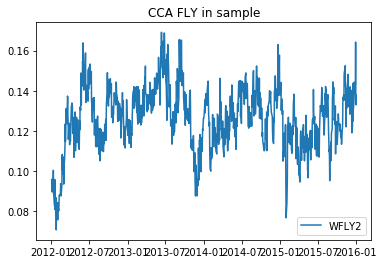

In [11]:
def BTCCA(df):
    Yt = df[["5 YR","7 YR","10 YR"]] - df[["5 YR","7 YR","10 YR"]].mean()
    Yt_1 = Yt.iloc[:-1]
    Yt = Yt.iloc[1:]
    cv0 = np.matrix(Yt.cov())

    # Yt(t) = A * Y(t-1)
    # A = [Y(t-1).T * Y(t-1)]^-1 * [Y(t-1).T*Y(t)]
    A = np.linalg.inv((np.matrix(Yt_1).T*np.matrix(Yt_1)))*np.matrix(Yt_1).T*np.matrix(Yt)
    
    #Q=Σ^-1A.TΣA
    Q = np.linalg.inv(cv0)*A.T*cv0*A
    x,vec = np.linalg.eig(Q)
    idx = np.argsort(x)[0]
    w_cca = [0,0,0]
    w_cca[0] = vec[0,idx]/(-vec[1,idx])
    w_cca[1] = -1
    w_cca[2] = vec[2,idx]/(-vec[1,idx])
    return w_cca

WFLY2_wts = BTCCA(df)
WFLY2 = pd.Series(WFLY2_wts[0]*df['5 YR'] + WFLY2_wts[1]*df['7 YR'] + WFLY2_wts[2]*df['10 YR'])
print('Box Tiao CCA weights are:\n\n[W1_5Yr  W_7Yr  W2_10Yr]:', WFLY2_wts)
plt.figure()
plt.plot(WFLY2, label = 'WFLY2')
plt.legend(loc = 'best')
plt.title('CCA FLY in sample')
plt.show()

## Q3

## Compute Half-Life & ADF statistic for WFLY1, WFLY2 using Sample1, compare results

### a.	Note that you are using time series of levels, not daily differences

In [12]:
def half_life(df):
    import statsmodels.api as sm
    mu = df.mean()
    df_t = df[:-1] - mu
    df_lag = df[1:] - mu
    OLS = sm.OLS(np.array(df_lag),np.array(df_t)).fit()
    print (OLS.summary())
    hf = (math.log(0.5)/math.log(OLS.params[0]))
    return hf

def adf_test(df):
    adf = adfuller(df,autolag='t-stat')
    print('ADF stats: ', adf[0])
    print('ADF p-values: ',adf[1])
    if adf[0]<=adf[4]['5%']:
        print('\nSince ADF Statistics is less than or euqal to t-statistics at 95% confidence interval.')
        print('Time Series is stationary\n')
    else:
        print('\nSince ADF Statistics is greater than t-statistics at 95% confidence interval.')
        print('Time series is not stationary\n')
    return ""

In [13]:
#half_life statistics
def half_life1(x):
    x_lag = x.shift(-1)
    Y = (x - x_lag)[:-1]
    X = sm.add_constant(x_lag)[:-1]
    model = sm.OLS(Y,X).fit()
    hl = -np.log(2)/model.params[1]
    return  round(hl, 4)

print('The half-life of WFLY1 is:', np.round(half_life1(WFLY2),decimals=2))

The half-life of WFLY1 is: 6.01


In [14]:
print('The half-life of WFLY1 is:', np.round(half_life(WFLY1),decimals=2))
print( )
print('ADFuller Test for WFLY1 is:')
print(adf_test(WFLY1))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 2.449e+04
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:46:53   Log-Likelihood:                 3527.6
No. Observations:                1000   AIC:                            -7053.
Df Residuals:                     999   BIC:                            -7048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9811      0.006    156.483      0.0

In [15]:
print('The half-life of WFLY2 is:', np.round(half_life(WFLY2),decimals=2))
print( )
print('ADFuller Test for WFLY2 is:')
print(adf_test(WFLY2))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     3544.
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:46:53   Log-Likelihood:                 3484.1
No. Observations:                1000   AIC:                            -6966.
Df Residuals:                     999   BIC:                            -6961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8818      0.015     59.529      0.0

## Q4.	Repeat Step #3 out-of-sample: using 3m, 6m, 12m out of sample periods

In [16]:
Three_mo = data.loc['2016-1-1':'2016-3-31']
Six_mo = data.loc['2016-1-1':'2016-6-30']
Twelve_mo = data.loc['2016-1-1':'2016-12-31']

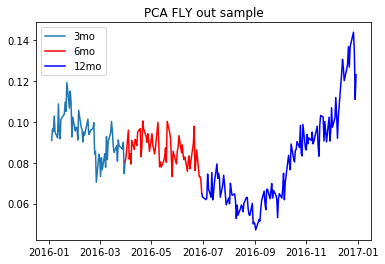

In [17]:
WFLY1_3mo = pd.Series(WFLY1_wts[0]*Three_mo['5 YR'] + WFLY1_wts[1]*Three_mo['7 YR'] + WFLY1_wts[2]*Three_mo['10 YR'])
WFLY1_6mo = pd.Series(WFLY1_wts[0]*Six_mo['5 YR'] + WFLY1_wts[1]*Six_mo['7 YR'] + WFLY1_wts[2]*Six_mo['10 YR'])
WFLY1_12mo = pd.Series(WFLY1_wts[0]*Twelve_mo['5 YR'] + WFLY1_wts[1]*Twelve_mo['7 YR'] + WFLY1_wts[2]*Twelve_mo['10 YR'])
[plt.plot(WFLY1_3mo),plt.plot(WFLY1_6mo['2016-3-31':'2016-6-30'],'r'),plt.plot(WFLY1_12mo['2016-6-30':'2016-12-31'],'b')]
plt.legend(['3mo','6mo','12mo'])
plt.title('PCA FLY out sample')
plt.show()

In [18]:
print('The half-life of WFLY1 3 months out of sample is:', np.round(half_life(WFLY1_3mo),decimals=2))
print('\nADFuller Test for WFLY1 3 months out of sample is:')
print(adf_test(WFLY1_3mo))

print('\n\n\nThe half-life of WFLY1 6 months out of sample is:', np.round(half_life(WFLY1_6mo),decimals=2))
print('\nADFuller Test for WFLY1 6 months out of sample is:')
print(adf_test(WFLY1_6mo))

print('\n\n\nThe half-life of WFLY1 12 months out of sample is:', np.round(half_life(WFLY1_12mo),decimals=2))
print('\nADFuller Test for WFLY1 12 months out of sample is:')
print(adf_test(WFLY1_12mo))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     43.19
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           1.43e-08
Time:                        11:46:54   Log-Likelihood:                 207.47
No. Observations:                  60   AIC:                            -412.9
Df Residuals:                      59   BIC:                            -410.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6586      0.100      6.572      0.0

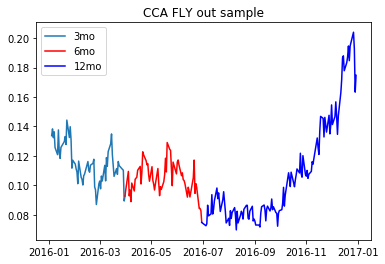

In [19]:
#Chou-Ng is similar to CCA
WFLY2_3mo = pd.Series(WFLY2_wts[0]*Three_mo['5 YR'] + WFLY2_wts[1]*Three_mo['7 YR'] + WFLY2_wts[2]*Three_mo['10 YR'])
WFLY2_6mo = pd.Series(WFLY2_wts[0]*Six_mo['5 YR'] + WFLY2_wts[1]*Six_mo['7 YR'] + WFLY2_wts[2]*Six_mo['10 YR'])
WFLY2_12mo = pd.Series(WFLY2_wts[0]*Twelve_mo['5 YR'] + WFLY2_wts[1]*Twelve_mo['7 YR'] + WFLY2_wts[2]*Twelve_mo['10 YR'])
[plt.plot(WFLY2_3mo),plt.plot(WFLY2_6mo['2016-3-31':'2016-6-30'],'r'),plt.plot(WFLY2_12mo['2016-6-30':'2016-12-31'],'b')]
plt.legend(['3mo','6mo','12mo'])
plt.title('CCA FLY out sample')
plt.show()

In [20]:
print('The half-life of WFLY2 3 months out of sample is:', np.round(half_life(WFLY2_3mo),decimals=2))
print('\nADFuller Test for WFLY2 3 months out of sample is:')
print(adf_test(WFLY2_3mo))

print('\n\n\nThe half-life of WFLY2 6 months out of sample is:', np.round(half_life(WFLY2_6mo),decimals=2))
print('\nADFuller Test for WFLY2 6 months out of sample is:')
print(adf_test(WFLY2_6mo))

print('\n\n\nThe half-life of WFLY2 12 months out of sample is:', np.round(half_life(WFLY2_12mo),decimals=2))
print('\nADFuller Test for WFLY2 12 months out of sample is:')
print(adf_test(WFLY2_12mo))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     82.16
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           8.94e-13
Time:                        11:46:54   Log-Likelihood:                 201.40
No. Observations:                  60   AIC:                            -400.8
Df Residuals:                      59   BIC:                            -398.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7694      0.085      9.064      0.0

### a.	How do out-of-sample results compare across periods and combinations?

* WFLY1 is not stationary for both in-sample and out-of-sample
* WFLY2 is stationary in sample but non-stationary out-of-sample

Let's analyze why the time series of WFLY1 (In-sample & out-of-sample) and WFLY2 (out-of-sample) are not stationary. I think the change in the monetary policy stance and market perception of Fed's policy action are at the core of the non-stationarity. To mention few points, on December 18, 2013, FOMC announed tapering back on QE3 at a rate of $ 10 billion at each meeting and in october 2014 Fed ended QE3. On December 2015, Fed hiked FFR interest rate first time since 2006. As we can see the sample we have chosen for analysis was full of action on Monetary Policy front. Also, there was lot of uncertainity in 2016 about impending US presidential election. I believe all these factors affected the stationarity of time series. While WFLY2 is stationary in-sample. So, we can say CCA by Box-Taio does a good job as a method of identifying mean reverting portfolio at least in-sample

## Q5

### a.	Explain the rationale for sparse decomposition algorithms

Sparse decomposition algorithms are designed to solve the problem to find extremal (max or min) generalized eigenvalues while
constraining the cardinality of coefficient vector under some given constant k (which means the portfolio have only less than k
assets having non-zero weight). It actually is an NP-hard problem.

The essay gives us two methods to solve the problem approximately. First is greedy search and second is semidefinite relaxation.

In greedy search method, what we do is solving the problem recursively on k. We can easily find the solution of the problem when
k=1. Then suppose we have a good solution when k=n, we simply add one asset to the portfolio and find the one gives us max
generalized eigenvalue. During this procedure, we solve (n-k) generalized eigenvalue problem of size (k+1). We continue this
procedure to find the approximately optimal value. Although this method not a good fit since support set(the index of assets
having non-zero weights) may not be increasing, it is relatively efficient as the complexity is O(n^4).

In semidefinite relaxation, we can relax the restriction to a convex constraint and do some equivalent change of the problem.
Then we use some standard SDP solvers to solve the problem and get an approximation which is actually an upper limit of true 
optimal value. It has been proved to be both well-performed and more efficient.

### b.	Describe & compare results in Figures 1 and 6

Figure 1 & 6 gives decomposition on US swap rates and shows eight portfolios of swap rates with maturities ranging from 1 to 30 years, ranked according to predictability. While Figure 1 uses Box & Taio CCA for decomposition, on the other hand, Figure 6 uses a sparse algorithm for selection of assets to be included in the portfolio. 

Results clearly show the upper hand of the sparse algorithm in selecting the optimally mean reverting portfolios. For example, for Two asset portfolio, the speed of mean reversion in Box Tia is 16 while that of the sparse algorithm is 35 more than double. For portfolios with the number of assets 3, 4, and 5 the speed of mean reversion for the sparse algorithm is almost that of Box-Taio. So, the paper suggests that the optimal mean reverting assets can more advantageously be identified using the sparse algorithm.